In [71]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score, confusion_matrix
import xgboost as xgb
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle("Data/df.pkl")
df.dropna(inplace = True)

In [3]:
y_probs_1 = np.load('Data/y_probs_1.npy')
y_probs_2 = np.load('Data/y_probs_2.npy')
y_test_custom = np.load('Data/y_test_custom.npy')

## Random Forest Classifier

In [5]:
#Converting features and labels to arrays for RF Classifier
labels = np.array(df['Recession'])
dates = df['Date']
features = df[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]
feature_list = list(features.columns)
features = np.array(features)

In [6]:
#Train, test split. Cannot do k-folds due to time series data
train_features, test_features = np.split(features, [int(.67 *len(features))])
train_labels, test_labels = np.split(labels, [int(.67 *len(labels))])

In [7]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (303, 3)
Training Labels Shape: (303,)
Testing Features Shape: (150, 3)
Testing Labels Shape: (150,)


In [8]:
def rolling_6(y_test):
    """
    Helper function to convert y_test to rolling 6 month window. 
    Returns numpy array: If recession occurs in 6 month window from index, returns 1. Otherwise, returns 0
    """
    rec_6_months = []
    
    for i in range(len(y_test)):
        if np.sum(y_test[i:i+6]) > 0:
            
            rec_6_months.append(1)    
        
        else:
            rec_6_months.append(0)
                
    return np.array(rec_6_months)

In [9]:
train_labels_custom = rolling_6(train_labels)
test_labels_custom = rolling_6(test_labels)

In [10]:
# Setting up Random Forest Grid Search
# After first pass, number of estimators was 100. Incrementing slightly
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto'],
    'max_depth' : [2,3,4,5,6,7,8],
    'criterion' :['gini']
}

rfc = RandomForestClassifier(n_jobs=-1, max_features= 'auto', n_estimators=50, oob_score = True)
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv= 5)
CV_rfc.fit(train_features, train_labels_custom)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'crite

In [11]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'n_estimators': 200}

In [12]:
# Instantiate best fit model
rf = RandomForestClassifier(n_estimators = 100, max_depth = 2, max_features = 'auto', criterion = 'gini')

# Train the model on training data
rf.fit(train_features, train_labels_custom);

In [13]:
predictions = rf.predict_proba(test_features) 

In [14]:
y_predict_3 = rf.predict(test_features)
print("The score for Random Forest is")
print("Test set AUC: {:6.2f}%".format(roc_auc_score(test_labels_custom, predictions[:,1])))
print("Default threshold: 0.5")
print("Test set Precision: {:6.4f}".format(precision_score(test_labels_custom, y_predict_3)))

The score for Random Forest is
Test set AUC:   0.76%
Default threshold: 0.5
Test set Precision: 0.3333


In [15]:
def make_confusion_matrix(model, threshold=0.3):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_3 = (rf.predict_proba(train_features)[:, 1] >= threshold)
    default_confusion = confusion_matrix(train_labels_custom, y_predict_3)
    plt.figure(dpi=80)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Growth', 'Recession'],
           yticklabels=['Growth', 'Recession']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("F1: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f}".format(fbeta_score(train_labels_custom, y_predict_3, beta = 1),
                                                                           precision_score(train_labels_custom, y_predict_3), 
                                                                           recall_score(train_labels_custom, y_predict_3)))

F1: 0.6500, Precision: 0.6000,   Recall: 0.7091


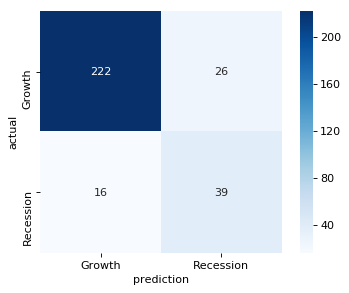

In [16]:
make_confusion_matrix(rf, 0.2)

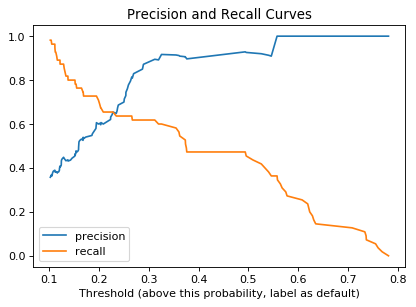

In [17]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(train_labels_custom, 
                                                                        rf.predict_proba(train_features)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as default)');
plt.title('Precision and Recall Curves')

fig_1 = plt.gcf()
fig_1.savefig('Data/logit_curves_1', format='png');

In [ ]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="NY Fed Model Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, predictions[:,1])
auc = metrics.roc_auc_score(test_labels_custom, predictions[:,1])
plt.plot(fpr,tpr,label="Random Forest, auc="+str(round(auc,2)))

plt.legend(loc='lower right');

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


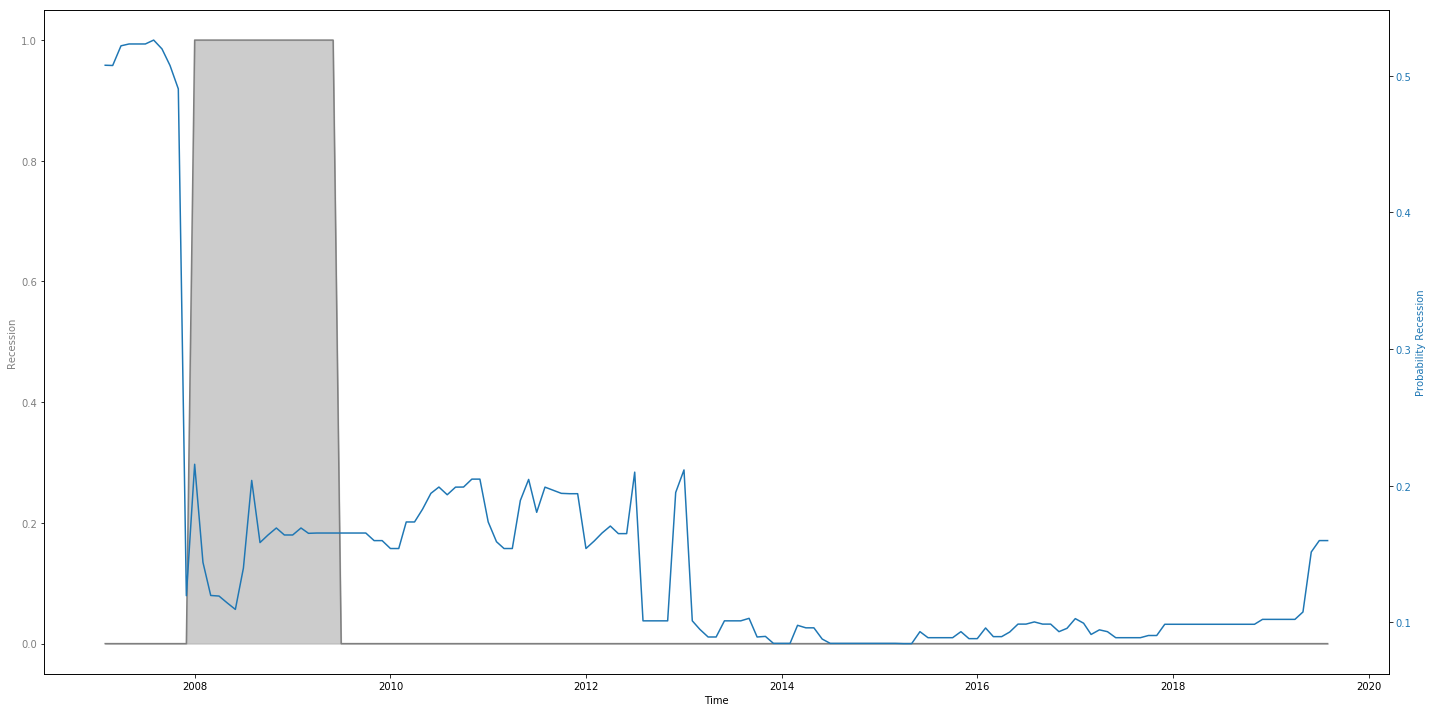

In [19]:
fig, ax1 = plt.subplots(figsize=(20,10))

test_labels = test_labels > 0
color = 'tab:grey'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.fill_between(dates[303:], 0, test_labels, alpha = 0.4, color = 'grey')
ax1.plot(dates[303:], test_labels, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(dates[303:], predictions[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show();

In [20]:
df.tail(3)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
462,2019-06-01,2.07,2.17,0,101.340371,-0.10,-6.255557,0.46,0.87,1.01,101.072907,101.359585,101.298915,-6.188920,-6.047863,-6.046656
463,2019-07-01,2.06,2.10,0,101.072671,-0.04,-6.285235,0.34,0.90,0.93,100.876346,101.342390,101.268674,-6.163211,-6.126769,-6.065144
464,2019-08-01,1.63,1.95,0,100.575301,-0.32,-6.398405,0.29,0.79,0.86,100.928805,101.237183,101.279514,-6.107702,-6.083086,-6.118759


In [21]:
now = rf.predict_proba([[-0.32,100.575,-6.3984]])
now

array([[0.45321145, 0.54678855]])

## XGBoost

In [59]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic')

In [60]:
clf = GridSearchCV(xgb,{'max_depth': [4,5,6],
                    'learning_rate' : [0.03, 0.01, 0.005, 0.001], 
                    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
                    'min_child_weight' : [4,5,6],
                    'n_estimators': [100,300,500,1000,3000]},
                    verbose=1, 
                    scoring='roc_auc')

clf.fit(train_features,train_labels_custom)
clf.best_score_, clf.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=1)]: Done 2700 out of 2700 | elapsed:  3.4min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(0.8421000481971268,
 {'learning_rate': 0.001,
  'max_depth': 5,
  'min_child_weight': 4,
  'n_estimators': 300,
  'reg_alpha': 0.05})

In [61]:
eval_set = [(train_features, train_labels)]

In [63]:
#Fit model with optimized parameters
xgbmodel = XGBClassifier(gamma = 0.4, learning_rate = 0.0001, max_depth = 5, min_child_weight = 4,
                         n_estimators = 300)

xgbmodel.fit(train_features, train_labels_custom, eval_metric="auc", eval_set=eval_set, 
             early_stopping_rounds = 10, verbose=True)

[0]	validation_0-auc:0.91807
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.91807
[2]	validation_0-auc:0.91807
[3]	validation_0-auc:0.91807
[4]	validation_0-auc:0.91807
[5]	validation_0-auc:0.91807
[6]	validation_0-auc:0.91807
[7]	validation_0-auc:0.91807
[8]	validation_0-auc:0.917964
[9]	validation_0-auc:0.917964
[10]	validation_0-auc:0.917857
Stopping. Best iteration:
[0]	validation_0-auc:0.91807



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.0001, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [64]:
xgb_proba = xgbmodel.predict_proba(test_features)

In [65]:
y_predict_4 = xgbmodel.predict(test_features)
print("The score for XGBoost is")
print("Test set AUC: {:6.2f}%".format(roc_auc_score(test_labels_custom, xgb_proba[:,1])))
print("Default threshold: 0.5")
print("Test set Precision: {:6.4f}".format(precision_score(test_labels_custom, y_predict_4)))

The score for XGBoost is
Test set AUC:   0.68%
Default threshold: 0.5
Test set Precision: 0.3333


In [66]:
def make_confusion_matrix(model, threshold=0.3):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_4 = (xgbmodel.predict_proba(train_features)[:, 1] >= threshold)
    default_confusion = confusion_matrix(train_labels_custom, y_predict_4)
    plt.figure(dpi=80)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Growth', 'Recession'],
           yticklabels=['Growth', 'Recession']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("F1: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f}".format(fbeta_score(train_labels_custom, y_predict_4, beta = 1),
                                                                           precision_score(train_labels_custom, y_predict_4), 
                                                                           recall_score(train_labels_custom, y_predict_4)))

F1: 0.3073, Precision: 0.1815,   Recall: 1.0000


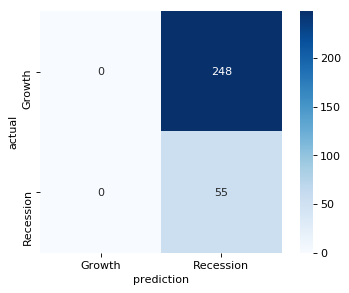

In [67]:
make_confusion_matrix(xgbmodel, 0.3)

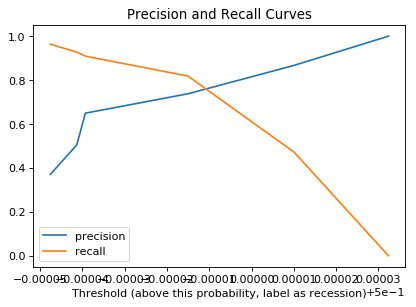

In [68]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(train_labels_custom, 
                                                                        xgbmodel.predict_proba(train_features)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as recession)');
plt.title('Precision and Recall Curves')

fig_1 = plt.gcf();

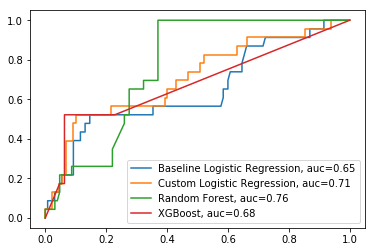

In [69]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="Baseline Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, predictions[:,1])
auc = metrics.roc_auc_score(test_labels_custom, predictions[:,1])
plt.plot(fpr,tpr,label="Random Forest, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, xgb_proba[:,1])
auc = metrics.roc_auc_score(test_labels_custom, xgb_proba[:,1])
plt.plot(fpr,tpr,label="XGBoost, auc="+str(round(auc,2)))

plt.legend(loc='lower right')
fig = plt.gcf()
fig.savefig('Data/ROC_curves', dpi = 300, format='png');

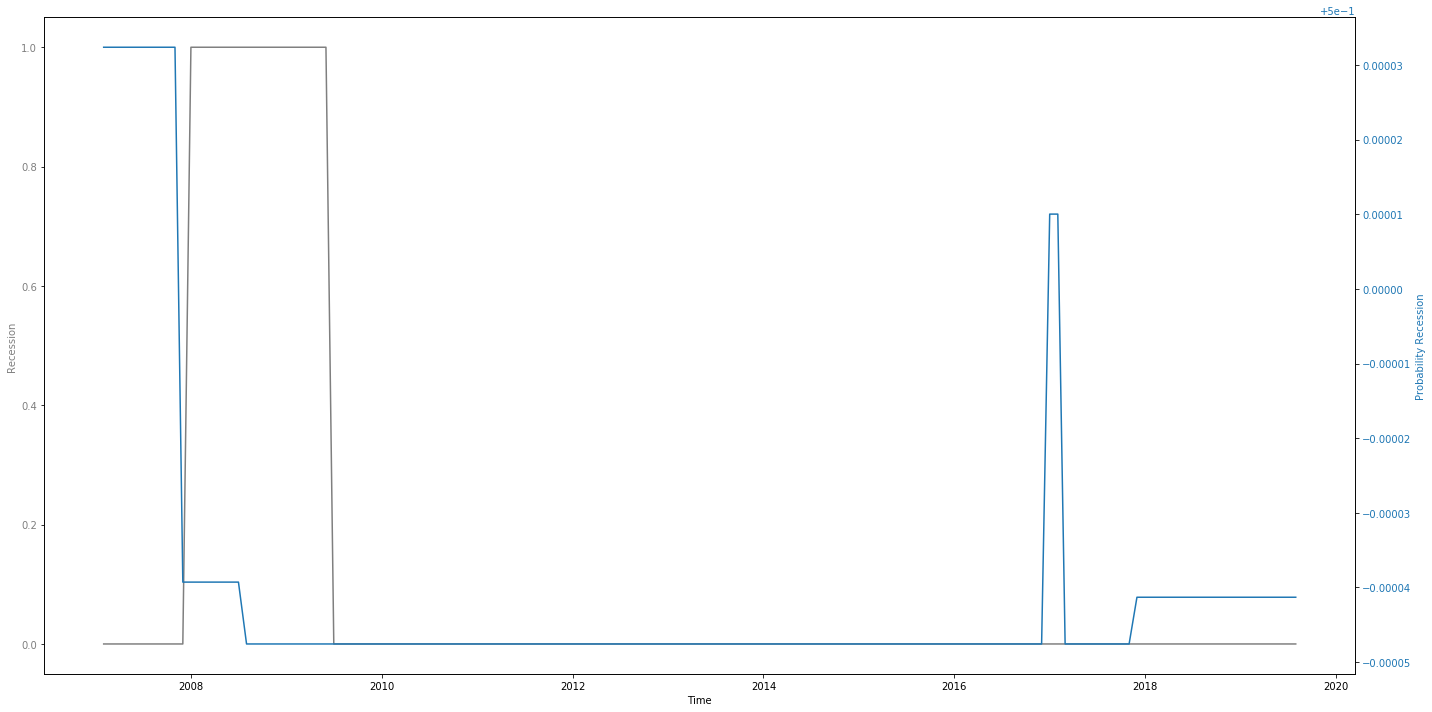

In [270]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:grey'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(dates[303:], test_labels, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(dates[303:], xgb_proba[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show();

In [200]:
now = xgbmodel.predict_proba([[-0.32,100.575,-6.3984]])
now

array([[0.2764455, 0.7235545]], dtype=float32)

## Naive Bayes

In [73]:
nb = GaussianNB()
nb.fit(train_features, train_labels_custom)

GaussianNB(priors=None, var_smoothing=1e-09)

In [74]:
nb_proba = nb.predict_proba(test_features)

In [75]:
y_predict_5 = nb.predict(test_features)
print("The score for XGBoost is")
print("Test set AUC: {:6.2f}%".format(roc_auc_score(test_labels_custom, nb_proba[:,1])))
print("Default threshold: 0.5")
print("Test set Precision: {:6.4f}".format(precision_score(test_labels_custom, y_predict_5)))

The score for XGBoost is
Test set AUC:   0.83%
Default threshold: 0.5
Test set Precision: 0.5000


In [76]:
def make_confusion_matrix(model, threshold=0.3):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_5 = (nb.predict_proba(train_features)[:, 1] >= threshold)
    default_confusion = confusion_matrix(train_labels_custom, y_predict_5)
    plt.figure(dpi=80)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Growth', 'Recession'],
           yticklabels=['Growth', 'Recession']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("F1: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f}".format(fbeta_score(train_labels_custom, y_predict_5, beta = 1),
                                                                           precision_score(train_labels_custom, y_predict_5), 
                                                                           recall_score(train_labels_custom, y_predict_5)))

F1: 0.5630, Precision: 0.4750,   Recall: 0.6909


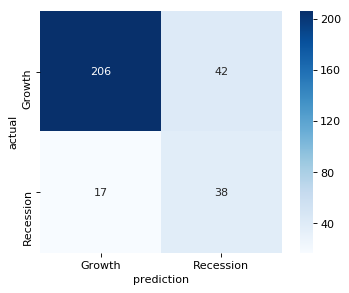

In [85]:
make_confusion_matrix(nb, 0.2)

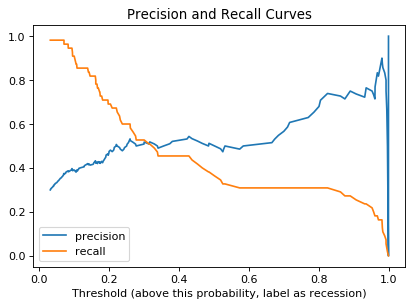

In [78]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(train_labels_custom, 
                                                                        nb.predict_proba(train_features)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as recession)');
plt.title('Precision and Recall Curves')

fig_1 = plt.gcf();

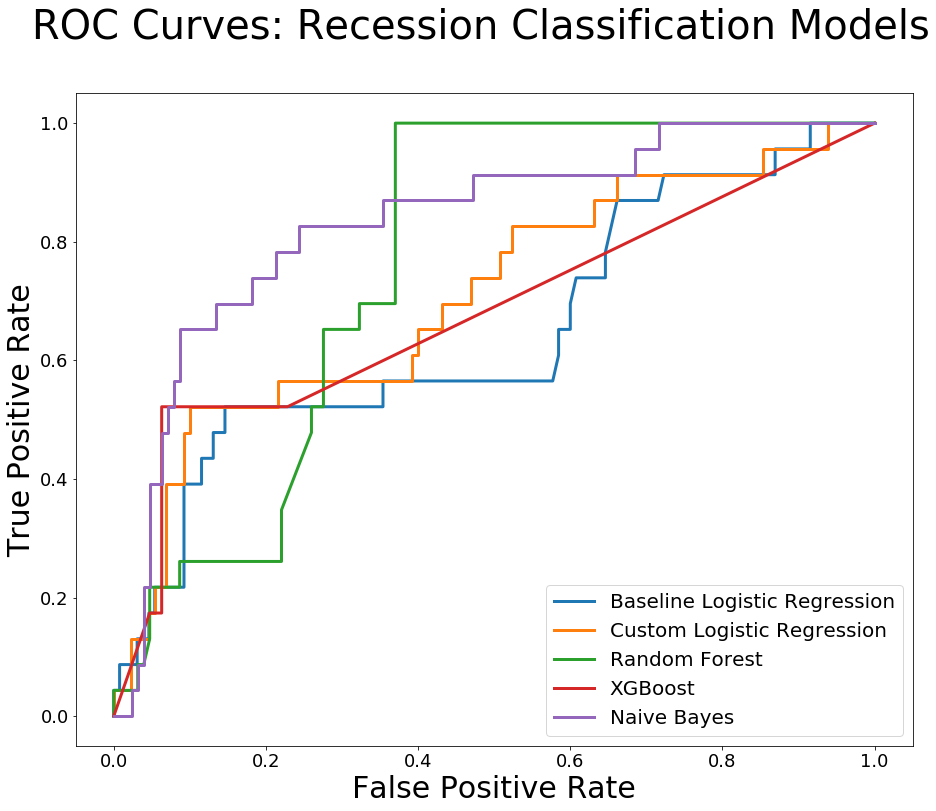

In [200]:
plt.figure(0).clf()


fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="Baseline Logistic Regression", linewidth = 3)

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logistic Regression", linewidth = 3)

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, predictions[:,1])
auc = metrics.roc_auc_score(test_labels_custom, predictions[:,1])
plt.plot(fpr,tpr,label="Random Forest", linewidth = 3)

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, xgb_proba[:,1])
auc = metrics.roc_auc_score(test_labels_custom, xgb_proba[:,1])
plt.plot(fpr,tpr,label="XGBoost", linewidth = 3)

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, nb_proba[:,1])
auc = metrics.roc_auc_score(test_labels_custom, nb_proba[:,1])
plt.plot(fpr,tpr,label="Naive Bayes", linewidth = 3)

plt.legend(loc='lower right', prop={'size': 20})
fig = plt.gcf()
plt.xlabel('False Positive Rate', fontsize=30)
plt.ylabel('True Positive Rate', fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.suptitle('ROC Curves: Recession Classification Models', fontsize = 40)
fig.set_size_inches(15, 12)
fig.savefig('Data/ROC_curves', dpi = 300, format='png');

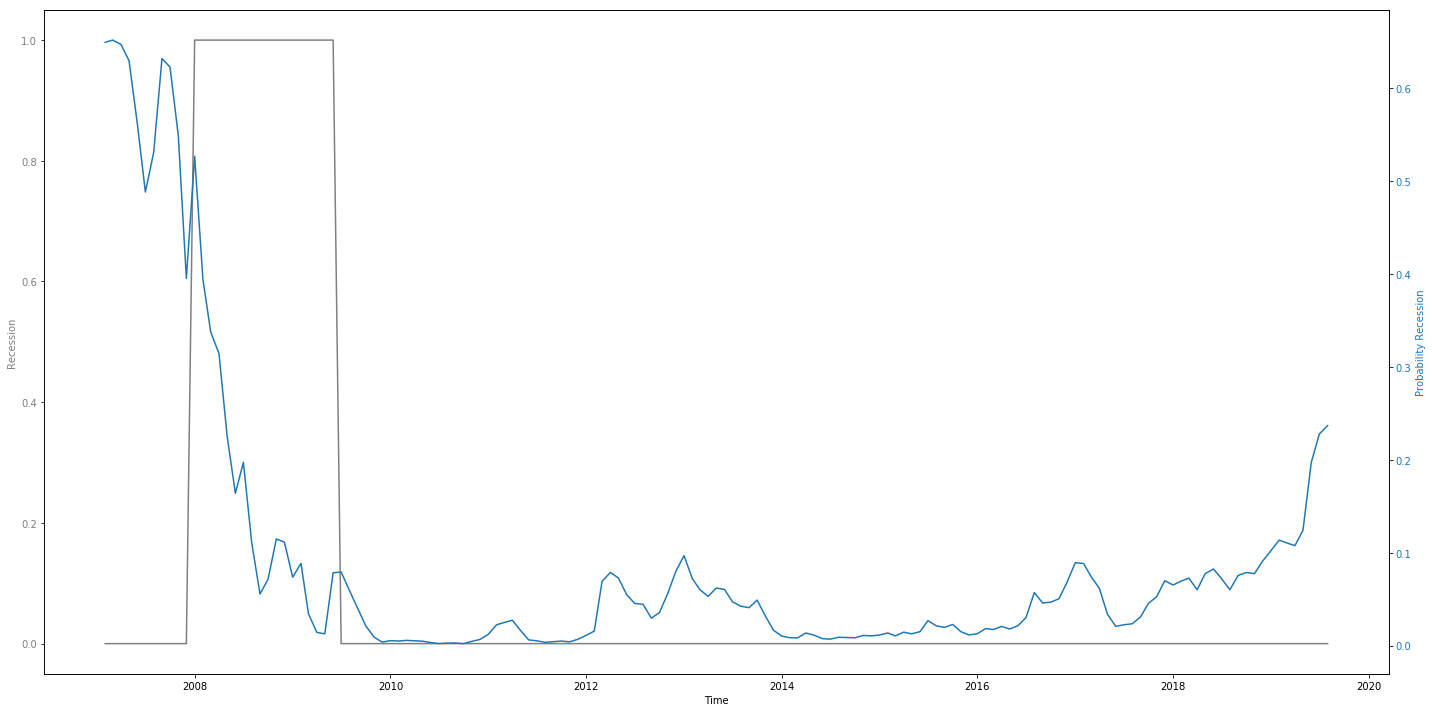

In [80]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:grey'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(dates[303:], test_labels, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(dates[303:], nb_proba[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show();

In [81]:
now = nb.predict_proba([[-0.32,100.575,-6.3984]])
now

array([[0.509906, 0.490094]])

## Current Probability Graph

In [120]:
df = pd.read_pickle("Data/df.pkl")

In [121]:
df.head()

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
0,1968-07-01,5.50,5.31,0,100.612032,0.19,-4.488816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-08-01,5.42,5.09,0,100.596721,0.33,-4.493680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-09-01,5.46,5.19,0,100.603771,0.27,-4.420542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-10-01,5.58,5.35,0,100.677831,0.23,-4.460540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-11-01,5.70,5.45,0,100.851819,0.25,-4.426410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
labels = np.array(df['Recession'])
dates = df['Date']
features = df[['10Y-3M','Consumer Sentiment','Copper/Gold']]
feature_list = list(features.columns)
features = np.array(features)

In [124]:
probs = nb.predict_proba(features)

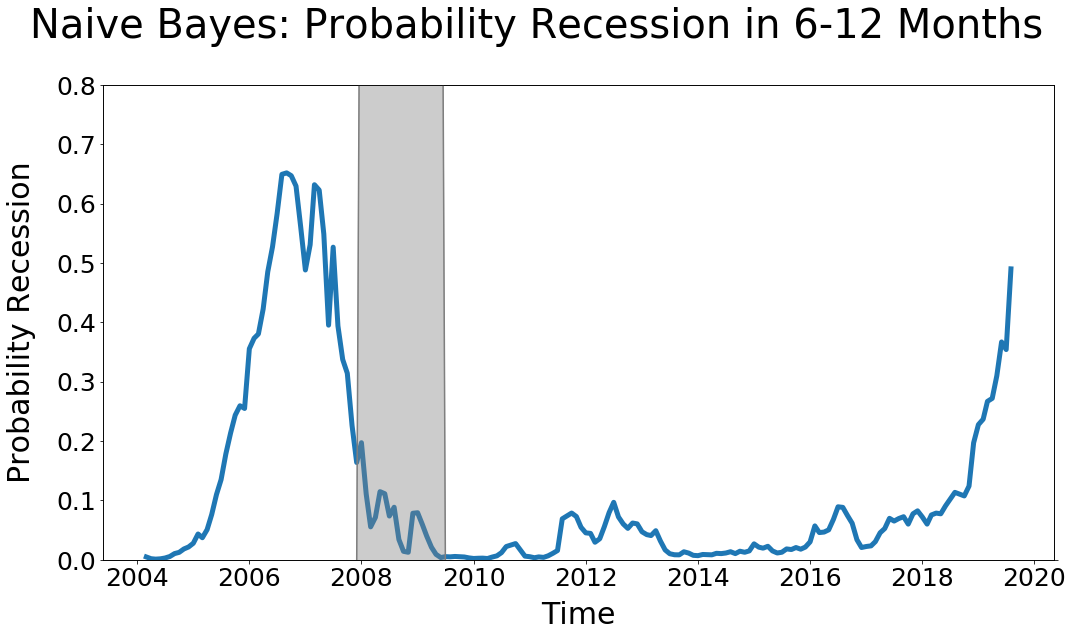

In [229]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:blue'
ax1.set_xlabel('Time', fontsize = 30, labelpad = 10)
ax1.set_ylabel('Probability Recession', color='black', fontsize = 30, labelpad = 20)
ax1.plot(dates[280:], probs[280:,1], color=color, linewidth = 5)
ax1.tick_params(axis='y', labelcolor='black', labelsize = 25)
ax1.tick_params(axis='x', labelcolor='black', labelsize = 25)
ax1.set_yticks(np.arange(0, 1, step=0.1))
ax1.set_ylim([0,0.8])

ax2 = ax1.twinx()  

color = 'tab:grey' 
ax2.plot(dates[280:], labels[280:], color=color)
ax2.fill_between(dates[280:], 0, labels[280:], alpha = 0.4, color = 'grey')
ax2.set_yticks(np.arange(0.01, 1, step=1))
ax2.set_ylim([0.01,0.5])
plt.setp(ax2.get_yticklabels(),visible=False)

fig.tight_layout()
fig.suptitle('Naive Bayes: Probability Recession in 6-12 Months', y = 1.10, fontsize=40)
fig.set_size_inches(15, 8)
fig.tight_layout()
fig.savefig('Data/prob_rec', dpi = 300, format='png')
plt.show();